In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
from common import *
import tensorflow as tf

set_random_seed(RANDOM_STATE)
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
    
exp_name = 'proposed28-include_lag'

2022-07-22 14:29:55.271529: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 14:29:55.273957: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 14:29:55.274125: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# 1. Load dataset

In [2]:
data_ = pd.read_csv(join(PATH.input, "train_data.csv"))
sample_submission = pd.read_csv(join(PATH.input, "sample_submission.csv"))
data_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3859200 entries, 0 to 3859199
Data columns (total 13 columns):
 #   Column   Dtype  
---  ------   -----  
 0   TurbID   int64  
 1   Day      int64  
 2   Tmstamp  object 
 3   Wspd     float64
 4   Wdir     float64
 5   Etmp     float64
 6   Itmp     float64
 7   Ndir     float64
 8   Pab1     float64
 9   Pab2     float64
 10  Pab3     float64
 11  Prtv     float64
 12  Patv     float64
dtypes: float64(10), int64(2), object(1)
memory usage: 382.8+ MB


# 2. Data processing

In [3]:
IN_SEQ_LEN  = 2*144
OUT_SEQ_LEN = 2*144
STRIDE      = 1
SHUFFLE     = False
VAL_SIZE    = 0.2

In [4]:
data = generate_full_timestamp(data_)

idxs_safe = data.query(f"Day >= 200-{IN_SEQ_LEN//144}").index
data1 = data.drop(idxs_safe)
data2 = data.loc[idxs_safe]

data1 = impute_data(data1)
# data1 = marking_data(data1, 0)
data1 = marking_data(data1, None).dropna()

data2 = data2.interpolate().bfill()

data_imp     = pd.concat([data1, data2])
data_imp_not = data.interpolate().bfill()

100%|██████████| 134/134 [00:09<00:00, 14.41it/s]


* Data name: Imputing
  - Number of data: 3765334
  - Number of nan rows: 0


In [5]:
df = copy(data_imp)
df

TurbID  Day Tmstamp  Wspd  Wdir   Etmp   Itmp    Ndir  Pab1  Pab2  Pab3    Prtv    Patv  \
0             1    1   00:00  6.17 -3.99  30.73  41.80   25.92  1.00  1.00  1.00   -0.25  494.66   
1             1    1   00:10  6.17 -3.99  30.73  41.80   25.92  1.00  1.00  1.00   -0.25  494.66   
2             1    1   00:20  6.27 -2.18  30.60  41.63   20.91  1.00  1.00  1.00   -0.24  509.76   
3             1    1   00:30  6.42 -0.73  30.52  41.52   20.91  1.00  1.00  1.00   -0.26  542.53   
4             1    1   00:40  6.25  0.89  30.49  41.38   20.91  1.00  1.00  1.00   -0.23  509.36   
...         ...  ...     ...   ...   ...    ...    ...     ...   ...   ...   ...     ...     ...   
3859195     134  200   23:10  4.86  4.68   9.04  10.40  174.39  0.01  0.01  0.01 -108.13  308.65   
3859196     134  200   23:20  4.46 -4.00   8.79  10.33  179.76  0.01  0.01  0.01  -93.64  221.60   
3859197     134  200   23:30  4.23 -0.08   8.74  10.22  172.35  0.01  0.01  0.01 -111.20  220.60   
3859198     134  200   23:40  4.36 -6.12   8.64  10.10  172.35  0.01  0.01  0.01 -108.04  222.15   
3859199     134  200   23:50  4.79 -3.65   8.53  10.01  168.58  0.01  0.01  0.01 -119.76  264.17   

          Time  
0            1  
1            2  
2            3  
3            4  
4            5  
...        ...  
3859195  28796  
3859196  28797  
3859197  28798  
3859198  28799  
3859199  28800  

[2980852 rows x 14 columns]

In [6]:
df = outlier_handler(df, ['Etmp', 'Itmp', 'Prtv'])

100%|██████████| 199/199 [00:11<00:00, 17.92it/s]


In [7]:
def process_features(data, lag=0, features_lag=None):
    data = copy(data)
    
    vals         = data['Wspd'].value_counts().index
    min_val      = vals[vals > 0][0]
    data['Wspd'] = data['Wspd'].clip(min_val, max(data['Wspd']))
    
    wd_rad        = np.deg2rad(data['Wdir'])
    data['WdirX'] = np.cos(wd_rad)
    data['WdirY'] = np.sin(wd_rad)
    
    data['WspdX'] = data['Wspd']*data['WdirX']
    data['WspdY'] = data['Wspd']*data['WdirY']
    
    data['Pab']  = (data['Pab1'] + data['Pab2'] + data['Pab3'])/3
    pab_rad      = np.deg2rad(data['Pab'])
    data['PabX'] = np.cos(pab_rad)
    data['PabY'] = np.sin(pab_rad)
    
    alpha = 40
    TSR1 = 1 / np.tan(np.radians((data['Pab1'] + alpha).apply(lambda x: min(x, 89)))).apply(lambda x: max(x, 0))
    TSR2 = 1 / np.tan(np.radians((data['Pab2'] + alpha).apply(lambda x: min(x, 89)))).apply(lambda x: max(x, 0))
    TSR3 = 1 / np.tan(np.radians((data['Pab3'] + alpha).apply(lambda x: min(x, 89)))).apply(lambda x: max(x, 0))
    data['TSR'] = (TSR1 + TSR2 + TSR3) / 3
    
    Bspd1 = TSR1 * data['WspdX']
    Bspd2 = TSR2 * data['WspdX']
    Bspd3 = TSR3 * data['WspdX']
    data['RPM'] = (Bspd1 + Bspd2 + Bspd3) / 3
    
    hours = data['Tmstamp'].map(lambda x: int(x.split(':')[0]) + int(x.split(':')[1]) / 60)
    data['HourX'] = np.cos(2 * np.pi * (hours / 24))
    data['HourY'] = np.sin(2 * np.pi * (hours / 24))
    
    c = 243.15
    data['Etmp_abs'] = data['Etmp'] + c
    
    if lag > 0:
        for col in features_lag:
            for lag in range(1, lag+1):
                data[f'{col}_lag{lag}'] = data[col].shift(lag)
        data.dropna(inplace=True)

    return data

lag = 3
features_lag = ['TSR', 'RPM', 'Wspd', 'Etmp', 'Itmp', 'PabX', 'PabY', 'WspdX', 'WspdY']
df_fe = process_features(df, lag=lag, features_lag=features_lag)
df_fe

TurbID  Day Tmstamp  Wspd  Wdir   Etmp   Itmp    Ndir  Pab1  Pab2  Pab3    Prtv    Patv  \
3             1    1   00:30  6.42 -0.73  30.52  41.52   20.91  1.00  1.00  1.00   -0.26  542.53   
4             1    1   00:40  6.25  0.89  30.49  41.38   20.91  1.00  1.00  1.00   -0.23  509.36   
5             1    1   00:50  6.10 -1.03  30.47  41.22   20.91  1.00  1.00  1.00   -0.27  482.21   
6             1    1   01:00  6.77  1.07  30.31  41.19   20.91  1.00  1.00  1.00   -0.23  584.75   
7             1    1   01:10  6.70 -2.80  30.24  41.00   20.91  1.00  1.00  1.00   -0.23  557.98   
...         ...  ...     ...   ...   ...    ...    ...     ...   ...   ...   ...     ...     ...   
3859195     134  200   23:10  4.86  4.68   9.04  10.40  174.39  0.01  0.01  0.01 -108.13  308.65   
3859196     134  200   23:20  4.46 -4.00   8.79  10.33  179.76  0.01  0.01  0.01 -108.10  221.60   
3859197     134  200   23:30  4.23 -0.08   8.74  10.22  172.35  0.01  0.01  0.01 -108.07  220.60   
3859198     134  200   23:40  4.36 -6.12   8.64  10.10  172.35  0.01  0.01  0.01 -108.04  222.15   
3859199     134  200   23:50  4.79 -3.65   8.53  10.01  168.58  0.01  0.01  0.01 -108.04  264.17   

          Time     WdirX     WdirY     WspdX     WspdY   Pab      PabX      PabY       TSR  \
3            4  0.999919 -0.012741  6.419479 -0.081794  1.00  0.999848  0.017452  1.150368   
4            5  0.999879  0.015533  6.249246  0.097080  1.00  0.999848  0.017452  1.150368   
5            6  0.999838 -0.017976  6.099014 -0.109653  1.00  0.999848  0.017452  1.150368   
6            7  0.999826  0.018674  6.768819  0.126423  1.00  0.999848  0.017452  1.150368   
7            8  0.998806 -0.048850  6.692001 -0.327293  1.00  0.999848  0.017452  1.150368   
...        ...       ...       ...       ...       ...   ...       ...       ...       ...   
3859195  28796  0.996666  0.081591  4.843796  0.396530  0.01  1.000000  0.000175  1.191331   
3859196  28797  0.997564 -0.069756  4.449136 -0.311114  0.01  1.000000  0.000175  1.191331   
3859197  28798  0.999999 -0.001396  4.229996 -0.005906  0.01  1.000000  0.000175  1.191331   
3859198  28799  0.994301 -0.106611  4.335151 -0.464825  0.01  1.000000  0.000175  1.191331   
3859199  28800  0.997972 -0.063661  4.780284 -0.304938  0.01  1.000000  0.000175  1.191331   

              RPM     HourX     HourY  Etmp_abs  TSR_lag1  TSR_lag2  TSR_lag3  RPM_lag1  RPM_lag2  \
3        7.384766  0.991445  0.130526    273.67  1.150368  1.150368  1.150368  7.207590  7.080570   
4        7.188935  0.984808  0.173648    273.64  1.150368  1.150368  1.150368  7.384766  7.207590   
5        7.016113  0.976296  0.216440    273.62  1.150368  1.150368  1.150368  7.188935  7.384766   
6        7.786636  0.965926  0.258819    273.46  1.150368  1.150368  1.150368  7.016113  7.188935   
7        7.698267  0.953717  0.300706    273.39  1.150368  1.150368  1.150368  7.786636  7.016113   
...           ...       ...       ...       ...       ...       ...       ...       ...       ...   
3859195  5.770566  0.976296 -0.216440    252.19  1.191331  1.191331  1.191331  6.111415  5.093849   
3859196  5.300394  0.984808 -0.173648    251.94  1.191331  1.191331  1.191331  5.770566  6.111415   
3859197  5.039326  0.991445 -0.130526    251.89  1.191331  1.191331  1.191331  5.300394  5.770566   
3859198  5.164601  0.996195 -0.087156    251.79  1.191331  1.191331  1.191331  5.039326  5.300394   
3859199  5.694901  0.999048 -0.043619    251.68  1.191331  1.191331  1.191331  5.164601  5.039326   

         RPM_lag3  Wspd_lag1  Wspd_lag2  Wspd_lag3  Etmp_lag1  Etmp_lag2  Etmp_lag3  Itmp_lag1  \
3        7.080570       6.27       6.17       6.17      30.60      30.73      30.73      41.63   
4        7.080570       6.42       6.27       6.17      30.52      30.60      30.73      41.52   
5        7.207590       6.25       6.42       6.27      30.49      30.52      30.60      41.38   
6        7.384766       6.10       6.25       6.42      30.47      30.49  

In [8]:
d = df_fe
d

TurbID  Day Tmstamp  Wspd  Wdir   Etmp   Itmp    Ndir  Pab1  Pab2  Pab3    Prtv    Patv  \
3             1    1   00:30  6.42 -0.73  30.52  41.52   20.91  1.00  1.00  1.00   -0.26  542.53   
4             1    1   00:40  6.25  0.89  30.49  41.38   20.91  1.00  1.00  1.00   -0.23  509.36   
5             1    1   00:50  6.10 -1.03  30.47  41.22   20.91  1.00  1.00  1.00   -0.27  482.21   
6             1    1   01:00  6.77  1.07  30.31  41.19   20.91  1.00  1.00  1.00   -0.23  584.75   
7             1    1   01:10  6.70 -2.80  30.24  41.00   20.91  1.00  1.00  1.00   -0.23  557.98   
...         ...  ...     ...   ...   ...    ...    ...     ...   ...   ...   ...     ...     ...   
3859195     134  200   23:10  4.86  4.68   9.04  10.40  174.39  0.01  0.01  0.01 -108.13  308.65   
3859196     134  200   23:20  4.46 -4.00   8.79  10.33  179.76  0.01  0.01  0.01 -108.10  221.60   
3859197     134  200   23:30  4.23 -0.08   8.74  10.22  172.35  0.01  0.01  0.01 -108.07  220.60   
3859198     134  200   23:40  4.36 -6.12   8.64  10.10  172.35  0.01  0.01  0.01 -108.04  222.15   
3859199     134  200   23:50  4.79 -3.65   8.53  10.01  168.58  0.01  0.01  0.01 -108.04  264.17   

          Time     WdirX     WdirY     WspdX     WspdY   Pab      PabX      PabY       TSR  \
3            4  0.999919 -0.012741  6.419479 -0.081794  1.00  0.999848  0.017452  1.150368   
4            5  0.999879  0.015533  6.249246  0.097080  1.00  0.999848  0.017452  1.150368   
5            6  0.999838 -0.017976  6.099014 -0.109653  1.00  0.999848  0.017452  1.150368   
6            7  0.999826  0.018674  6.768819  0.126423  1.00  0.999848  0.017452  1.150368   
7            8  0.998806 -0.048850  6.692001 -0.327293  1.00  0.999848  0.017452  1.150368   
...        ...       ...       ...       ...       ...   ...       ...       ...       ...   
3859195  28796  0.996666  0.081591  4.843796  0.396530  0.01  1.000000  0.000175  1.191331   
3859196  28797  0.997564 -0.069756  4.449136 -0.311114  0.01  1.000000  0.000175  1.191331   
3859197  28798  0.999999 -0.001396  4.229996 -0.005906  0.01  1.000000  0.000175  1.191331   
3859198  28799  0.994301 -0.106611  4.335151 -0.464825  0.01  1.000000  0.000175  1.191331   
3859199  28800  0.997972 -0.063661  4.780284 -0.304938  0.01  1.000000  0.000175  1.191331   

              RPM     HourX     HourY  Etmp_abs  TSR_lag1  TSR_lag2  TSR_lag3  RPM_lag1  RPM_lag2  \
3        7.384766  0.991445  0.130526    273.67  1.150368  1.150368  1.150368  7.207590  7.080570   
4        7.188935  0.984808  0.173648    273.64  1.150368  1.150368  1.150368  7.384766  7.207590   
5        7.016113  0.976296  0.216440    273.62  1.150368  1.150368  1.150368  7.188935  7.384766   
6        7.786636  0.965926  0.258819    273.46  1.150368  1.150368  1.150368  7.016113  7.188935   
7        7.698267  0.953717  0.300706    273.39  1.150368  1.150368  1.150368  7.786636  7.016113   
...           ...       ...       ...       ...       ...       ...       ...       ...       ...   
3859195  5.770566  0.976296 -0.216440    252.19  1.191331  1.191331  1.191331  6.111415  5.093849   
3859196  5.300394  0.984808 -0.173648    251.94  1.191331  1.191331  1.191331  5.770566  6.111415   
3859197  5.039326  0.991445 -0.130526    251.89  1.191331  1.191331  1.191331  5.300394  5.770566   
3859198  5.164601  0.996195 -0.087156    251.79  1.191331  1.191331  1.191331  5.039326  5.300394   
3859199  5.694901  0.999048 -0.043619    251.68  1.191331  1.191331  1.191331  5.164601  5.039326   

         RPM_lag3  Wspd_lag1  Wspd_lag2  Wspd_lag3  Etmp_lag1  Etmp_lag2  Etmp_lag3  Itmp_lag1  \
3        7.080570       6.27       6.17       6.17      30.60      30.73      30.73      41.63   
4        7.080570       6.42       6.27       6.17      30.52      30.60      30.73      41.52   
5        7.207590       6.25       6.42       6.27      30.49      30.52      30.60      41.38   
6        7.384766       6.10       6.25       6.42      30.47      30.49  

In [9]:
# from statsmodels.tsa.seasonal import seasonal_decompose

# def decompose_features(data, cols):
#     data = data.copy()
    
#     for col in cols:
#         rst = seasonal_decompose(d[col], period=6, model='addititive', two_sided=True)  # nan is included in result
#         data[f'{col}_trend']    = rst.trend.bfill().ffill()
#         data[f'{col}_seasonal'] = rst.seasonal.bfill().ffill()
#         data[f'{col}_resid']    = rst.resid.bfill().ffill()
#         print(f"MAE(residual({col})): \t", (data[col] - (data[f'{col}_trend'] + data[f'{col}_seasonal'])).abs().mean())
    
# #     data.drop(columns=cols, inplace=True)
#     check_nan(data, "Decompose features")
#     return data

# d_decomp = decompose_features(d, ['Wspd', 'Etmp_abs', 'Itmp', 'Patv'])
# cols = ['TurbID', 'Patv',
#         'Wspd_trend', 'Wspd_seasonal',
#         'Etmp_abs_trend', 'Etmp_abs_seasonal',
#         'Itmp_trend', 'Itmp_seasonal',
#         'WdirX', 'WdirY', 'WspdX', 'WspdY',
#         'Patv_trend', 'Patv_seasonal']
# d_sel = d_decomp[cols]
# d_sel

In [10]:
cols = ['TurbID', 'Patv',
        'TSR', 'RPM', 'Wspd', 'Etmp', 'Itmp', 'PabX', 'PabY', 'WspdX', 'WspdY', 'HourX', 'HourY']

cols_lag = []
for col in features_lag:
    for lag in range(1, lag+1):
        cols_lag.append(f'{col}_lag{lag}')

cols_enc = [col for col in df_fe if col.startswith('TurbID_')]

d_sel = d[cols + cols_enc + cols_lag]
d_sel

TurbID    Patv       TSR       RPM  Wspd   Etmp   Itmp      PabX      PabY     WspdX  \
3             1  542.53  1.150368  7.384766  6.42  30.52  41.52  0.999848  0.017452  6.419479   
4             1  509.36  1.150368  7.188935  6.25  30.49  41.38  0.999848  0.017452  6.249246   
5             1  482.21  1.150368  7.016113  6.10  30.47  41.22  0.999848  0.017452  6.099014   
6             1  584.75  1.150368  7.786636  6.77  30.31  41.19  0.999848  0.017452  6.768819   
7             1  557.98  1.150368  7.698267  6.70  30.24  41.00  0.999848  0.017452  6.692001   
...         ...     ...       ...       ...   ...    ...    ...       ...       ...       ...   
3859195     134  308.65  1.191331  5.770566  4.86   9.04  10.40  1.000000  0.000175  4.843796   
3859196     134  221.60  1.191331  5.300394  4.46   8.79  10.33  1.000000  0.000175  4.449136   
3859197     134  220.60  1.191331  5.039326  4.23   8.74  10.22  1.000000  0.000175  4.229996   
3859198     134  222.15  1.191331  5.164601  4.36   8.64  10.10  1.000000  0.000175  4.335151   
3859199     134  264.17  1.191331  5.694901  4.79   8.53  10.01  1.000000  0.000175  4.780284   

            WspdY     HourX     HourY  TSR_lag1  TSR_lag2  TSR_lag3  RPM_lag1  RPM_lag2  RPM_lag3  \
3       -0.081794  0.991445  0.130526  1.150368  1.150368  1.150368  7.207590  7.080570  7.080570   
4        0.097080  0.984808  0.173648  1.150368  1.150368  1.150368  7.384766  7.207590  7.080570   
5       -0.109653  0.976296  0.216440  1.150368  1.150368  1.150368  7.188935  7.384766  7.207590   
6        0.126423  0.965926  0.258819  1.150368  1.150368  1.150368  7.016113  7.188935  7.384766   
7       -0.327293  0.953717  0.300706  1.150368  1.150368  1.150368  7.786636  7.016113  7.188935   
...           ...       ...       ...       ...       ...       ...       ...       ...       ...   
3859195  0.396530  0.976296 -0.216440  1.191331  1.191331  1.191331  6.111415  5.093849  5.383825   
3859196 -0.311114  0.984808 -0.173648  1.191331  1.191331  1.191331  5.770566  6.111415  5.093849   
3859197 -0.005906  0.991445 -0.130526  1.191331  1.191331  1.191331  5.300394  5.770566  6.111415   
3859198 -0.464825  0.996195 -0.087156  1.191331  1.191331  1.191331  5.039326  5.300394  5.770566   
3859199 -0.304938  0.999048 -0.043619  1.191331  1.191331  1.191331  5.164601  5.039326  5.300394   

         Wspd_lag1  Wspd_lag2  Wspd_lag3  Etmp_lag1  Etmp_lag2  Etmp_lag3  Itmp_lag1  Itmp_lag2  \
3             6.27       6.17       6.17      30.60      30.73      30.73      41.63      41.80   
4             6.42       6.27       6.17      30.52      30.60      30.73      41.52      41.63   
5             6.25       6.42       6.27      30.49      30.52      30.60      41.38      41.52   
6             6.10       6.25       6.42      30.47      30.49      30.52      41.22      41.38   
7             6.77       6.10       6.25      30.31      30.47      30.49      41.19      41.22   
...            ...        ...        ...        ...        ...        ...        ...        ...   
3859195       5.13       4.28       4.52       8.86       8.93       9.03      10.33      10.41   
3859196       4.86       5.13       4.28       9.04       8.86       8.93      10.40      10.33   
3859197       4.46       4.86       5.13       8.79       9.04       8.86      10.33      10.40   
3859198       4.23       4.46       4.86       8.74       8.79       9.04      10.22      10.33   
3859199       4.36       4.23       4.46       8.64       8.74       8.79      10.10      10.22   

         Itmp_lag3  PabX_lag1  PabX_lag2  PabX_lag3  PabY_lag1  PabY_lag2  PabY_lag3  WspdX_lag1  \
3            41.80   0.999848   0.999848   0.999848   0.017452   0.017452   0.017452    6.265462   
4            41.80   0.999848   0.999848   0.999848   0.017452   0.017452   0.017452    6.419479   
5            41.63   0.999848   0.999848   0.999848   0.017452   0.017452   0.017452    6.249246   
6            41.52   0.999848   0.999848  

# 3. Modeling

In [11]:
%%time
train_x, train_y, val_x, val_y, test_x = make_train_val_test_data(d[cols + cols_lag + ['Time']], IN_SEQ_LEN, OUT_SEQ_LEN, STRIDE, SHUFFLE, VAL_SIZE, drop_TurbID=False)

100%|██████████| 134/134 [00:53<00:00,  2.49it/s]


* Data Split
  - Train data(X, y)     : (2557, 288, 40) (2557, 288, 40)
  - Validation data(X, y): (505, 288, 40) (505, 288, 40)
  - Test data(X)         : (134, 288, 40)
CPU times: user 54.9 s, sys: 1.05 s, total: 55.9 s
Wall time: 54.9 s


In [12]:
train_x[0]

TurbID     Patv       TSR        RPM   Wspd    Etmp    Itmp      PabX      PabY      WspdX  \
Time                                                                                               
99         1   264.20  1.147534   5.538156   4.89  37.518  46.662  0.999826  0.018674   4.826138   
100        1   305.86  1.150368   4.922000   4.28  37.884  46.556  0.999848  0.017452   4.278629   
101        1   326.50  1.150774   6.077951   5.34  38.250  46.450  0.999851  0.017278   5.281620   
102        1    55.45  1.150774   4.315269   3.75  38.090  46.280  0.999851  0.017278   3.749884   
103        1     1.78  1.121193   3.908315   4.03  38.460  46.975  0.999544  0.030190   3.485855   
...      ...      ...       ...        ...    ...     ...     ...       ...       ...        ...   
382        1  1367.64  1.149558  11.734620  10.21  29.130  42.400  0.999842  0.017801  10.207943   
383        1  1377.27  1.149558  11.823374  10.32  29.200  42.530  0.999842  0.017801  10.285150   
384        1  1404.11  1.149558  12.116223  10.54  29.380  42.760  0.999842  0.017801  10.539900   
385        1  1350.66  1.149558  11.679276  10.16  29.430  42.920  0.999842  0.017801  10.159799   
386        1  1349.24  1.149963  11.428041   9.94  29.400  42.870  0.999845  0.017627   9.937747   

         WspdY     HourX     HourY  TSR_lag1  TSR_lag2  TSR_lag3   RPM_lag1   RPM_lag2   RPM_lag3  \
Time                                                                                                
99    0.787716 -0.422618 -0.906308  1.152804  1.153211  1.123559   4.264474   4.267331   6.157072   
100   0.108304 -0.382683 -0.923880  1.147534  1.152804  1.153211   5.538156   4.264474   4.267331   
101  -0.787459 -0.342020 -0.939693  1.150368  1.147534  1.152804   4.922000   5.538156   4.264474   
102   0.029452 -0.300706 -0.953717  1.150774  1.150368  1.147534   6.077951   4.922000   5.538156   
103   2.022305 -0.258819 -0.965926  1.150774  1.150774  1.150368   4.315269   6.077951   4.922000   
...        ...       ...       ...       ...       ...       ...        ...        ...        ...   
382   0.204914 -0.608761 -0.793353  1.149558  1.149153  1.148343  11.986848  12.680862  13.537709   
383  -0.847401 -0.573576 -0.819152  1.149558  1.149558  1.149153  11.734620  11.986848  12.680862   
384  -0.045989 -0.537300 -0.843391  1.149558  1.149558  1.149558  11.823374  11.734620  11.986848   
385   0.063837 -0.500000 -0.866025  1.149558  1.149558  1.149558  12.116223  11.823374  11.734620   
386   0.211637 -0.461749 -0.887011  1.149558  1.149558  1.149558  11.679276  12.116223  11.823374   

      Wspd_lag1  Wspd_lag2  Wspd_lag3  Etmp_lag1  Etmp_lag2  Etmp_lag3  Itmp_lag1  Itmp_lag2  \
Time                                                                                           
99         3.75       3.75       5.61     37.152     36.786     36.420     46.768     46.874   
100        4.89       3.75       3.75     37.518     37.152     36.786     46.662     46.768   
101        4.28       4.89       3.75     37.884     37.518     37.152     46.556     46.662   
102        5.34       4.28       4.89     38.250     37.884     37.518     46.450     46.556   
103        3.75       5.34       4.28     38.090     38.250     37.884     46.280     46.450   
...         ...        ...        ...        ...        ...        ...        ...        ...   
382       10.43      11.04      11.79     28.920     28.720     28.540     42.290     42.190   
383       10.21      10.43      11.04     29.130     28.920     28.720     42.400     42.290   
384       10.32      10.21      10.43     29.200     29.130     28.920     42.530     42.400   
385       10.54      10.32      10.21     29.380     29.200     29.130     42.760     42.530   
386       10.16      10.54      10.32     29.430     29.380     29.200     42.920     42.760   

      Itmp_lag3  PabX_lag1  PabX_lag2  PabX_lag3  PabY_lag1  PabY_lag2  PabY_lag3  WspdX_lag1  \
Time                                         

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(d_sel)

train_x_norm = scale(train_x, scaler)
train_y_norm = scale(train_y, scaler)
val_x_norm   = scale(val_x, scaler)
val_y_norm   = scale(val_y, scaler)
test_x_norm  = scale(test_x, scaler)

In [14]:
sample = train_x[0].iloc[0:1]
idx_Patv = list(sample).index('Patv')

sample['Patv'] = 0
Patv_min_scaled = scale(sample, scaler)[0][idx_Patv]

sample['Patv'] = 1500
Patv_max_scaled = scale(sample, scaler)[0][idx_Patv]

Patv_min_scaled, Patv_max_scaled

(-1.0664328, 2.4115355)

In [15]:
BATCH_SIZE = 32

train_ds = generate_dataset(train_x_norm, train_y_norm, batch_size=BATCH_SIZE, shuffle=True)
val_ds   = generate_dataset(val_x_norm, val_y_norm, batch_size=BATCH_SIZE, shuffle=True)
test_ds  = generate_dataset(test_x_norm, batch_size=1)

2022-07-22 14:31:35.652197: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-22 14:31:35.652952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 14:31:35.653228: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 14:31:35.653421: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [16]:
from tensorflow import keras
from tensorflow.keras import layers


class OutputLayer(layers.Layer):
    def __init__(self, min_val, max_val, **kwags):
        super().__init__(**kwags)
        self.min_val = min_val
        self.max_val = max_val
    def call(self, data):
        _, B, F = data.shape
        TurbID, Patv, *other = tf.split(data, data.shape[2], axis=2)
        Patv = tf.clip_by_value(Patv, self.min_val, self.max_val)
        return tf.concat([TurbID, Patv, *other], axis=2)
    def get_config(self):
        return super().get_config()
    
    
def build_model(input_shape, output_shape, units, n_blocks, dropout=None):
    S,  F  = input_shape
    S_, F_ = output_shape
    
    model = keras.Sequential(name="GRU-Model") # Model
    model.add(keras.Input(shape=(S, F), name='Input-Layer'))

    for _ in range(n_blocks+1):
        model.add(layers.Bidirectional(layers.GRU(units, return_sequences=True, dropout=dropout)))
    
    model.add(layers.Dense(units=F_))
    model.add(OutputLayer(Patv_min_scaled, Patv_max_scaled))
    return model

In [17]:
from tensorflow.keras import losses, metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from livelossplot import PlotLossesKeras

class PartialLoss(losses.Loss):
    def __init__(self, loss_fn, last_idx, **kwargs):
        super().__init__(**kwargs)
        self.loss_fn  = loss_fn
        self.last_idx = last_idx
    def call(self, y_true, y_pred):
        _, S, F = y_true.shape
        
        # [0]: TurbID
        y_true = y_true[:, :, 1:self.last_idx]
        y_pred = y_pred[:, :, 1:self.last_idx]
        res = y_true - y_pred

        if self.loss_fn == 'rmse':
            return tf.sqrt(tf.reduce_mean(tf.square(res)))
        elif self.loss_fn == 'mse':
            return tf.reduce_mean(tf.square(res))
        elif self.loss_fn == 'mae':
            return tf.reduce_mean(tf.abs(res))
        else:
            raise NotImplementedError

            
def compile_and_fit(model, train_ds, val_ds, epochs, patience_es=10, patience_lr=3):
    model.compile('nadam', loss=PartialLoss(loss_fn='rmse', last_idx=len(cols)), metrics=[metrics.RootMeanSquaredError(), 'mae'])
    
    ckpt_dir = join(PATH.ckpt, exp_name)
    os.makedirs(ckpt_dir, exist_ok=True)
    
    return model.fit(train_ds, validation_data=val_ds,
                    epochs=epochs,
                    callbacks=[
                        PlotLossesKeras(),
                        EarlyStopping(patience=patience_es, restore_best_weights=True),
                        ReduceLROnPlateau(patience=patience_lr),
                        ModelCheckpoint(join(ckpt_dir, '[{epoch:03d} epoch].h5'), save_best_only=False, save_weights_only=True),
                    ])

In [18]:
model = build_model(input_shape=train_x[0].shape, output_shape=train_y[0].shape, units=256, n_blocks=4, dropout=0.3)
model.summary()

Model: "GRU-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 288, 512)         457728    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 288, 512)         1182720   
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 288, 512)         1182720   
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 288, 512)         1182720   
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 288, 512)         11

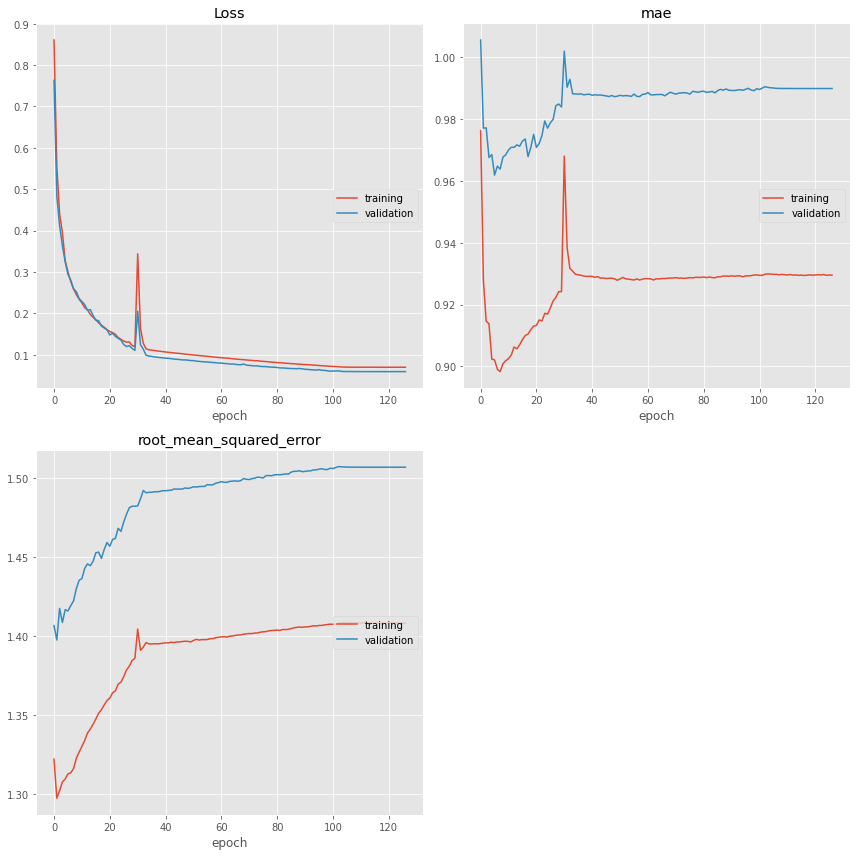

Loss
	training         	 (min:    0.070, max:    0.861, cur:    0.070)
	validation       	 (min:    0.059, max:    0.763, cur:    0.059)
mae
	training         	 (min:    0.898, max:    0.976, cur:    0.930)
	validation       	 (min:    0.962, max:    1.006, cur:    0.990)
root_mean_squared_error
	training         	 (min:    1.297, max:    1.409, cur:    1.408)
	validation       	 (min:    1.398, max:    1.507, cur:    1.507)
80/80 [==============================] - 18s 223ms/step - loss: 0.0698 - root_mean_squared_error: 1.4083 - mae: 0.9295 - val_loss: 0.0592 - val_root_mean_squared_error: 1.5070 - val_mae: 0.9899 - lr: 1.0000e-11


In [19]:
compile_and_fit(model, train_ds, val_ds, epochs=1000, patience_es=15, patience_lr=3)

In [20]:
def plot_result(model, scaler, Pmax_params, n_cols=5):
    for ds in (train_ds, val_ds):
        for X, y in ds.take(1):
            X = X[:n_cols]
            y = y[:n_cols]
        
        inputs = [pd.DataFrame(inverse_scale(d, scaler), columns=cols + cols_lag) for d in X]
        trues  = [pd.DataFrame(inverse_scale(d, scaler), columns=cols + cols_lag) for d in y]
        preds  = [pd.DataFrame(inverse_scale(d, scaler), columns=cols + cols_lag) for d in model.predict(X, verbose=0)]
        
        for input, pred in zip(inputs, preds):
            pred['TurbID'] = input['TurbID'].round().values
#             pred['Patv']   = compute_Pmax(pred, **Pmax_params)

        n_rows = len(cols)
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(40, 20))
        for ax_col, col in zip(axes, cols):
            for idx_row, (ax, true, pred) in enumerate(zip(ax_col, trues, preds)):
                ax.plot(true[col], label='true')
                ax.plot(pred[col], label=f'pred ({np.mean(abs(pred[col]-true[col])):.3f})')
                ax.fill_between(range(len(true[col])), true[col], pred[col], alpha=0.1, color='b')
                ax.set_xticklabels([])
                ax.legend()
                if idx_row == 0:
                    ax.set_ylabel(col)
        fig.tight_layout()
        plt.show()

In [21]:
Pmax_params = {
    'constants'       : compute_Pmax_constants(d),
    'clipping_min_val': 0,
    'clipping_max_val': 1500
}

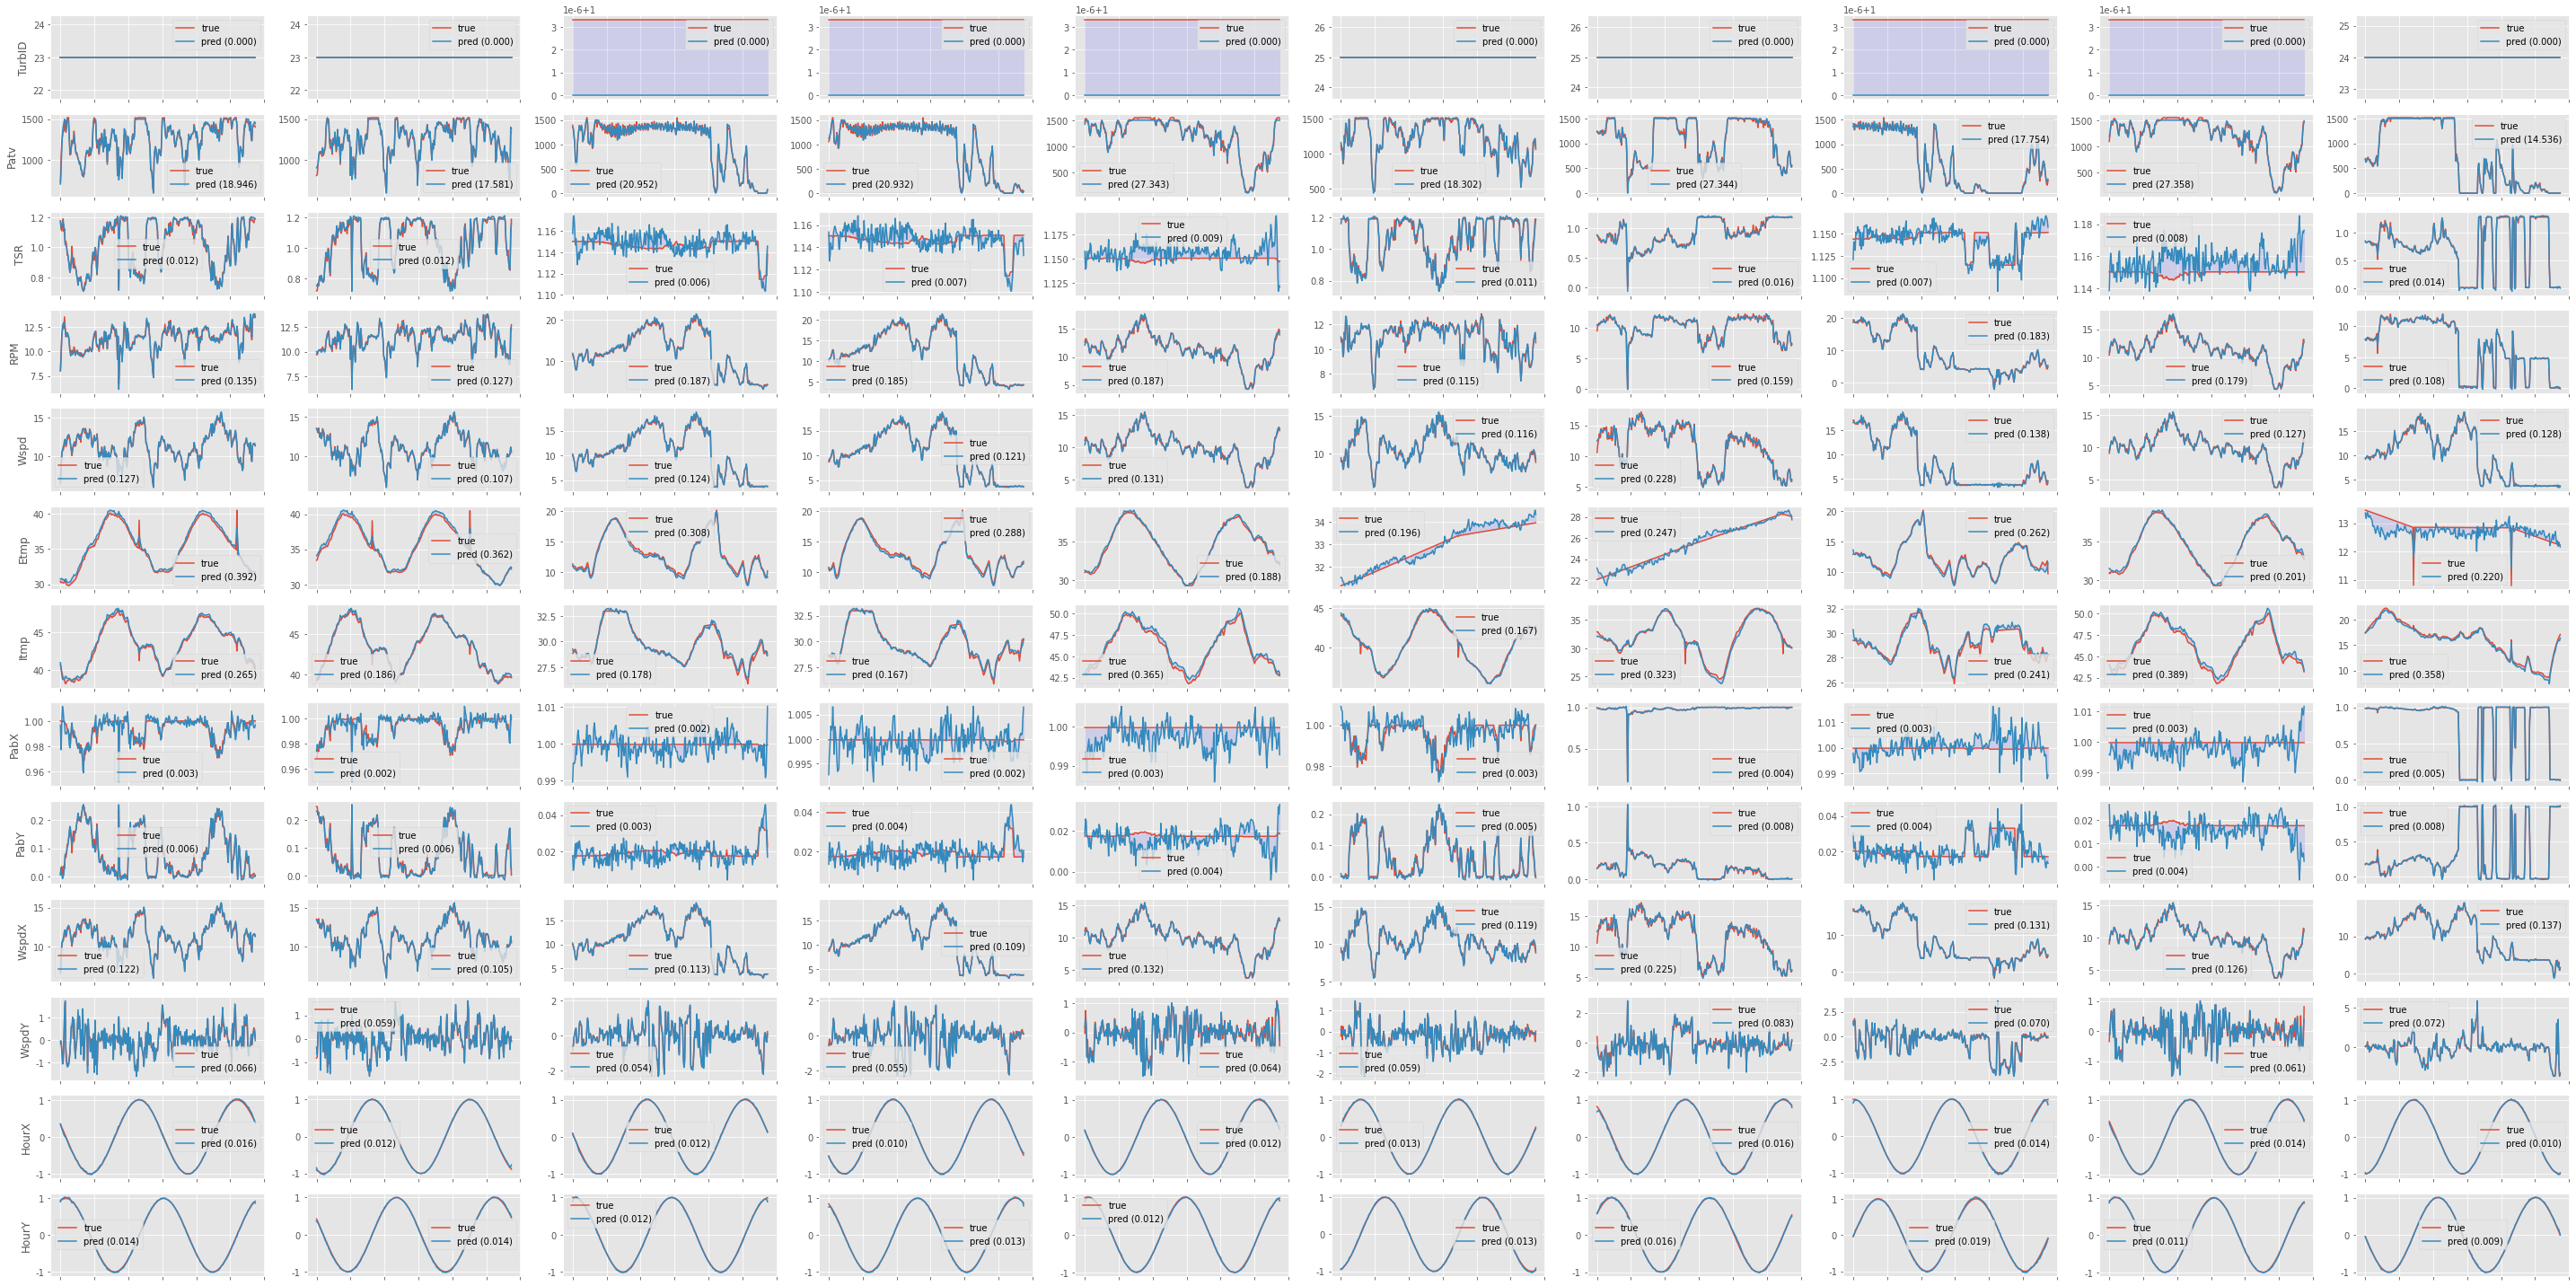

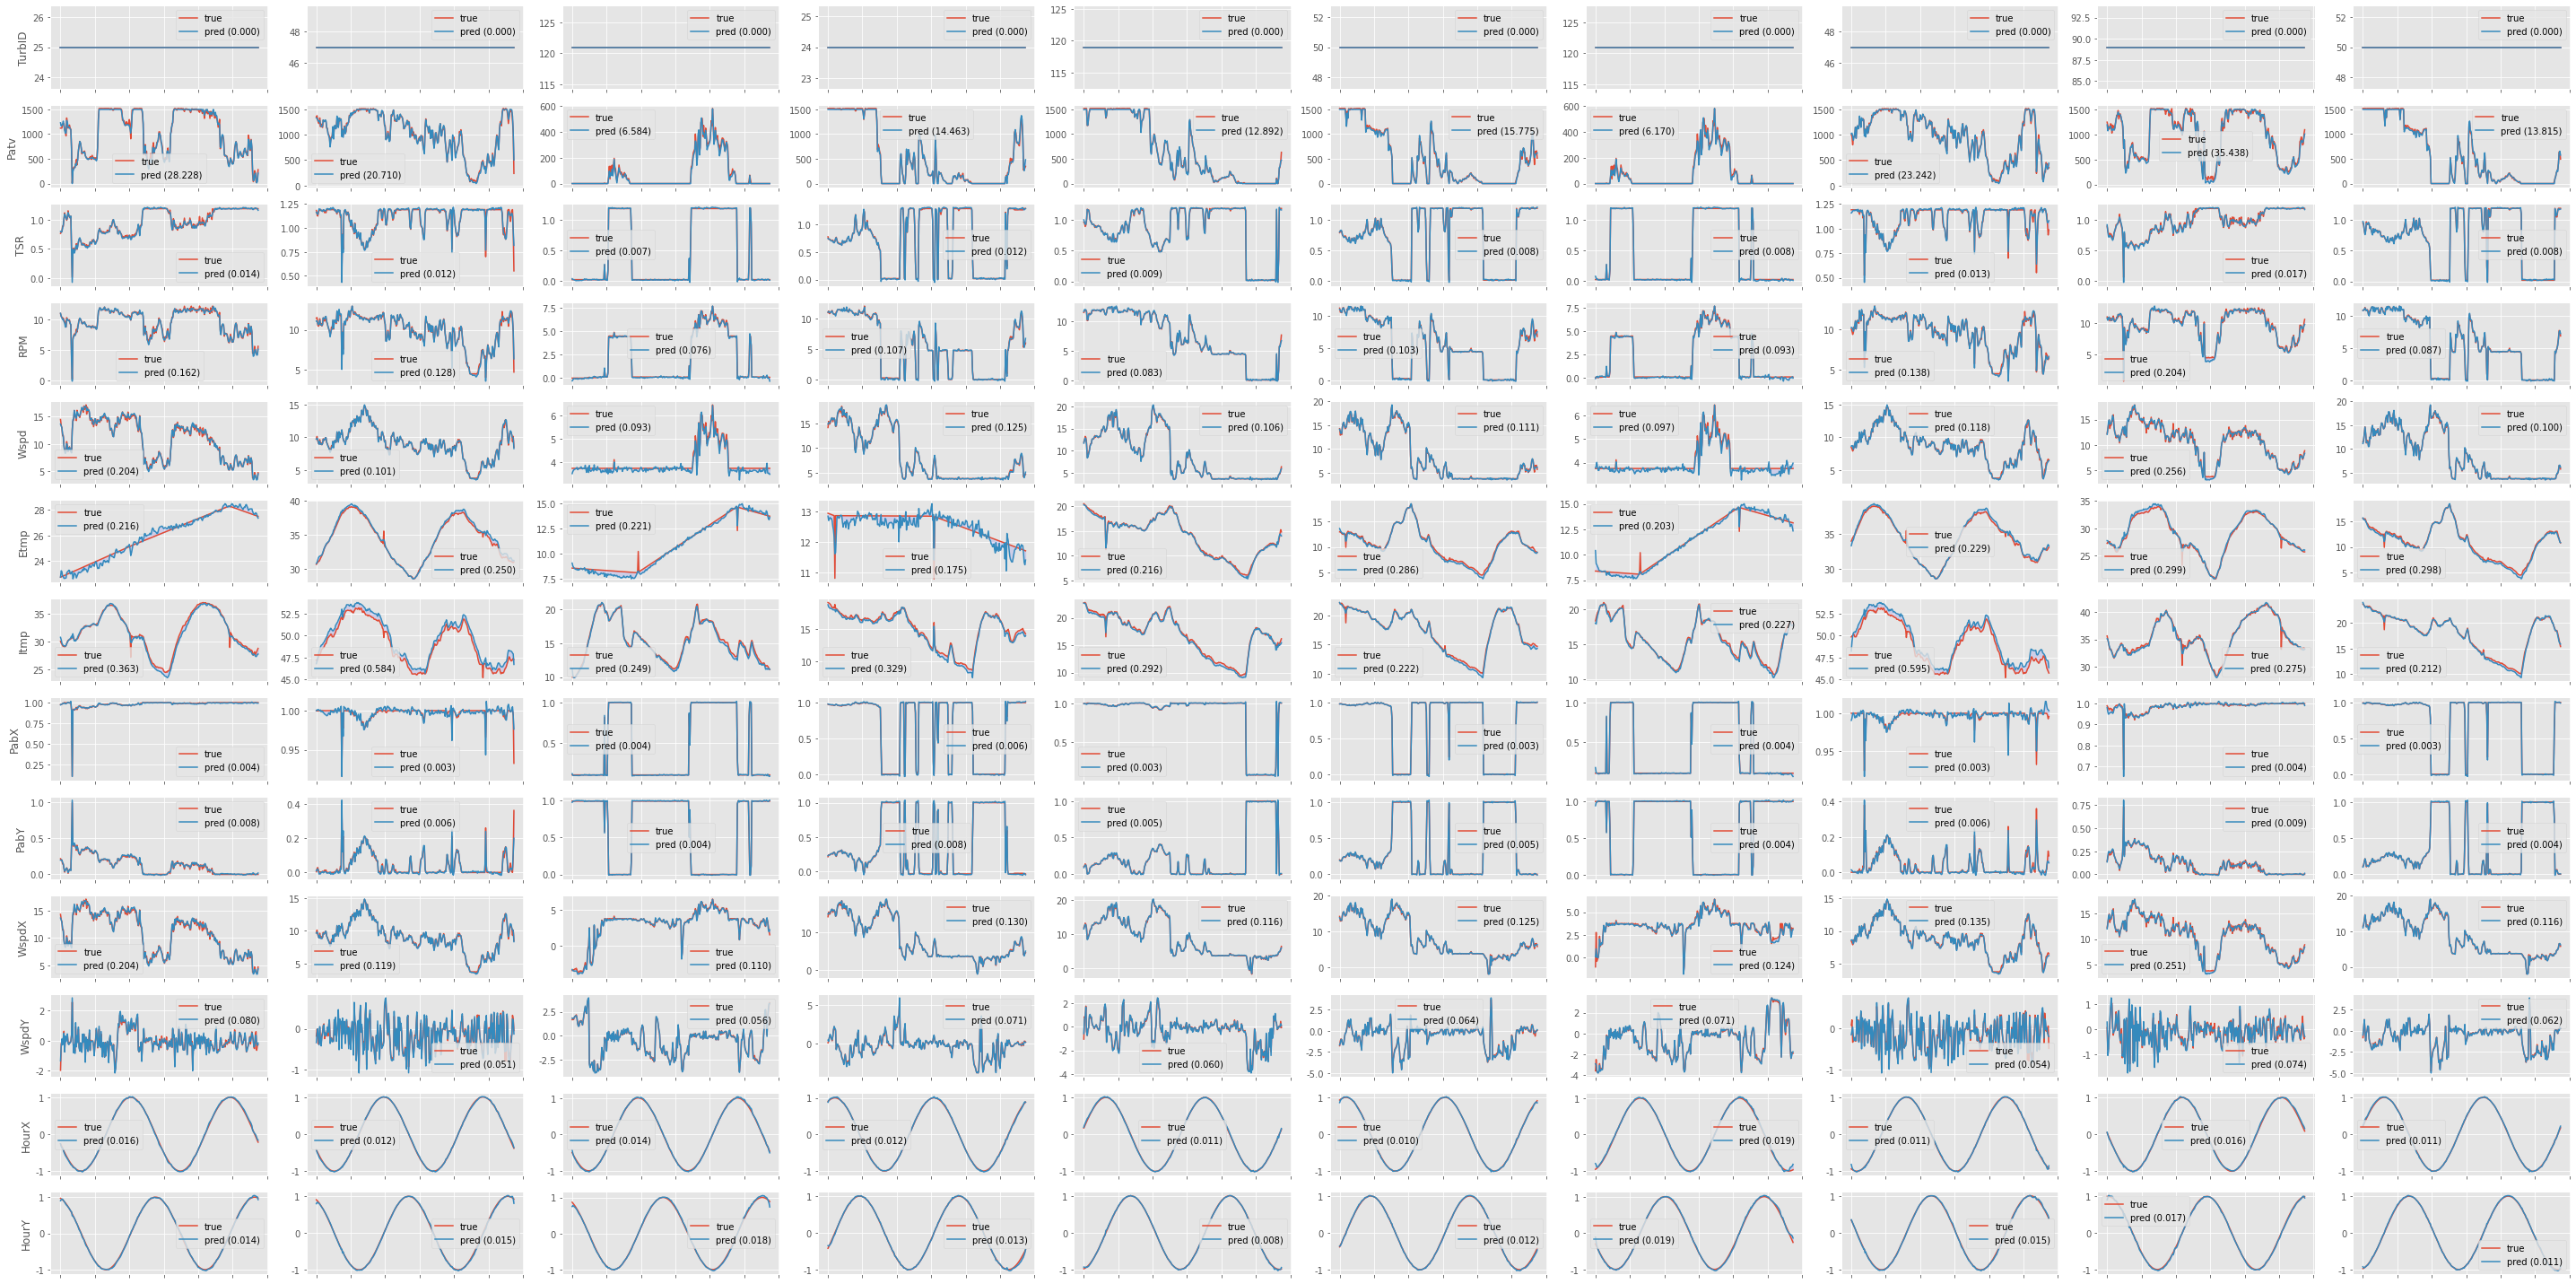

In [22]:
plot_result(model, scaler, Pmax_params, n_cols=10)

In [25]:
def compute_test_Patv(model, test_x, test_ds, cols, Pmax_params):
    X      = pd.concat(test_x)
    y_pred = inverse_scale(model.predict(test_ds), scaler).reshape(-1, X.shape[-1])
    y_pred = pd.DataFrame(y_pred, columns=cols)

#     y_pred['TurbID'] = X['TurbID'].round().values
#     y_pred['Patv']   = compute_Pmax(y_pred, **Pmax_params)
    return y_pred['Patv']

sample_submission['Patv'] = compute_test_Patv(model, test_x, test_ds, cols + cols_enc + cols_lag, Pmax_params)
sample_submission.to_csv(join(PATH.output, f"{exp_name}.csv"), index=False)

134/134 [==============================] - 11s 79ms/step


---

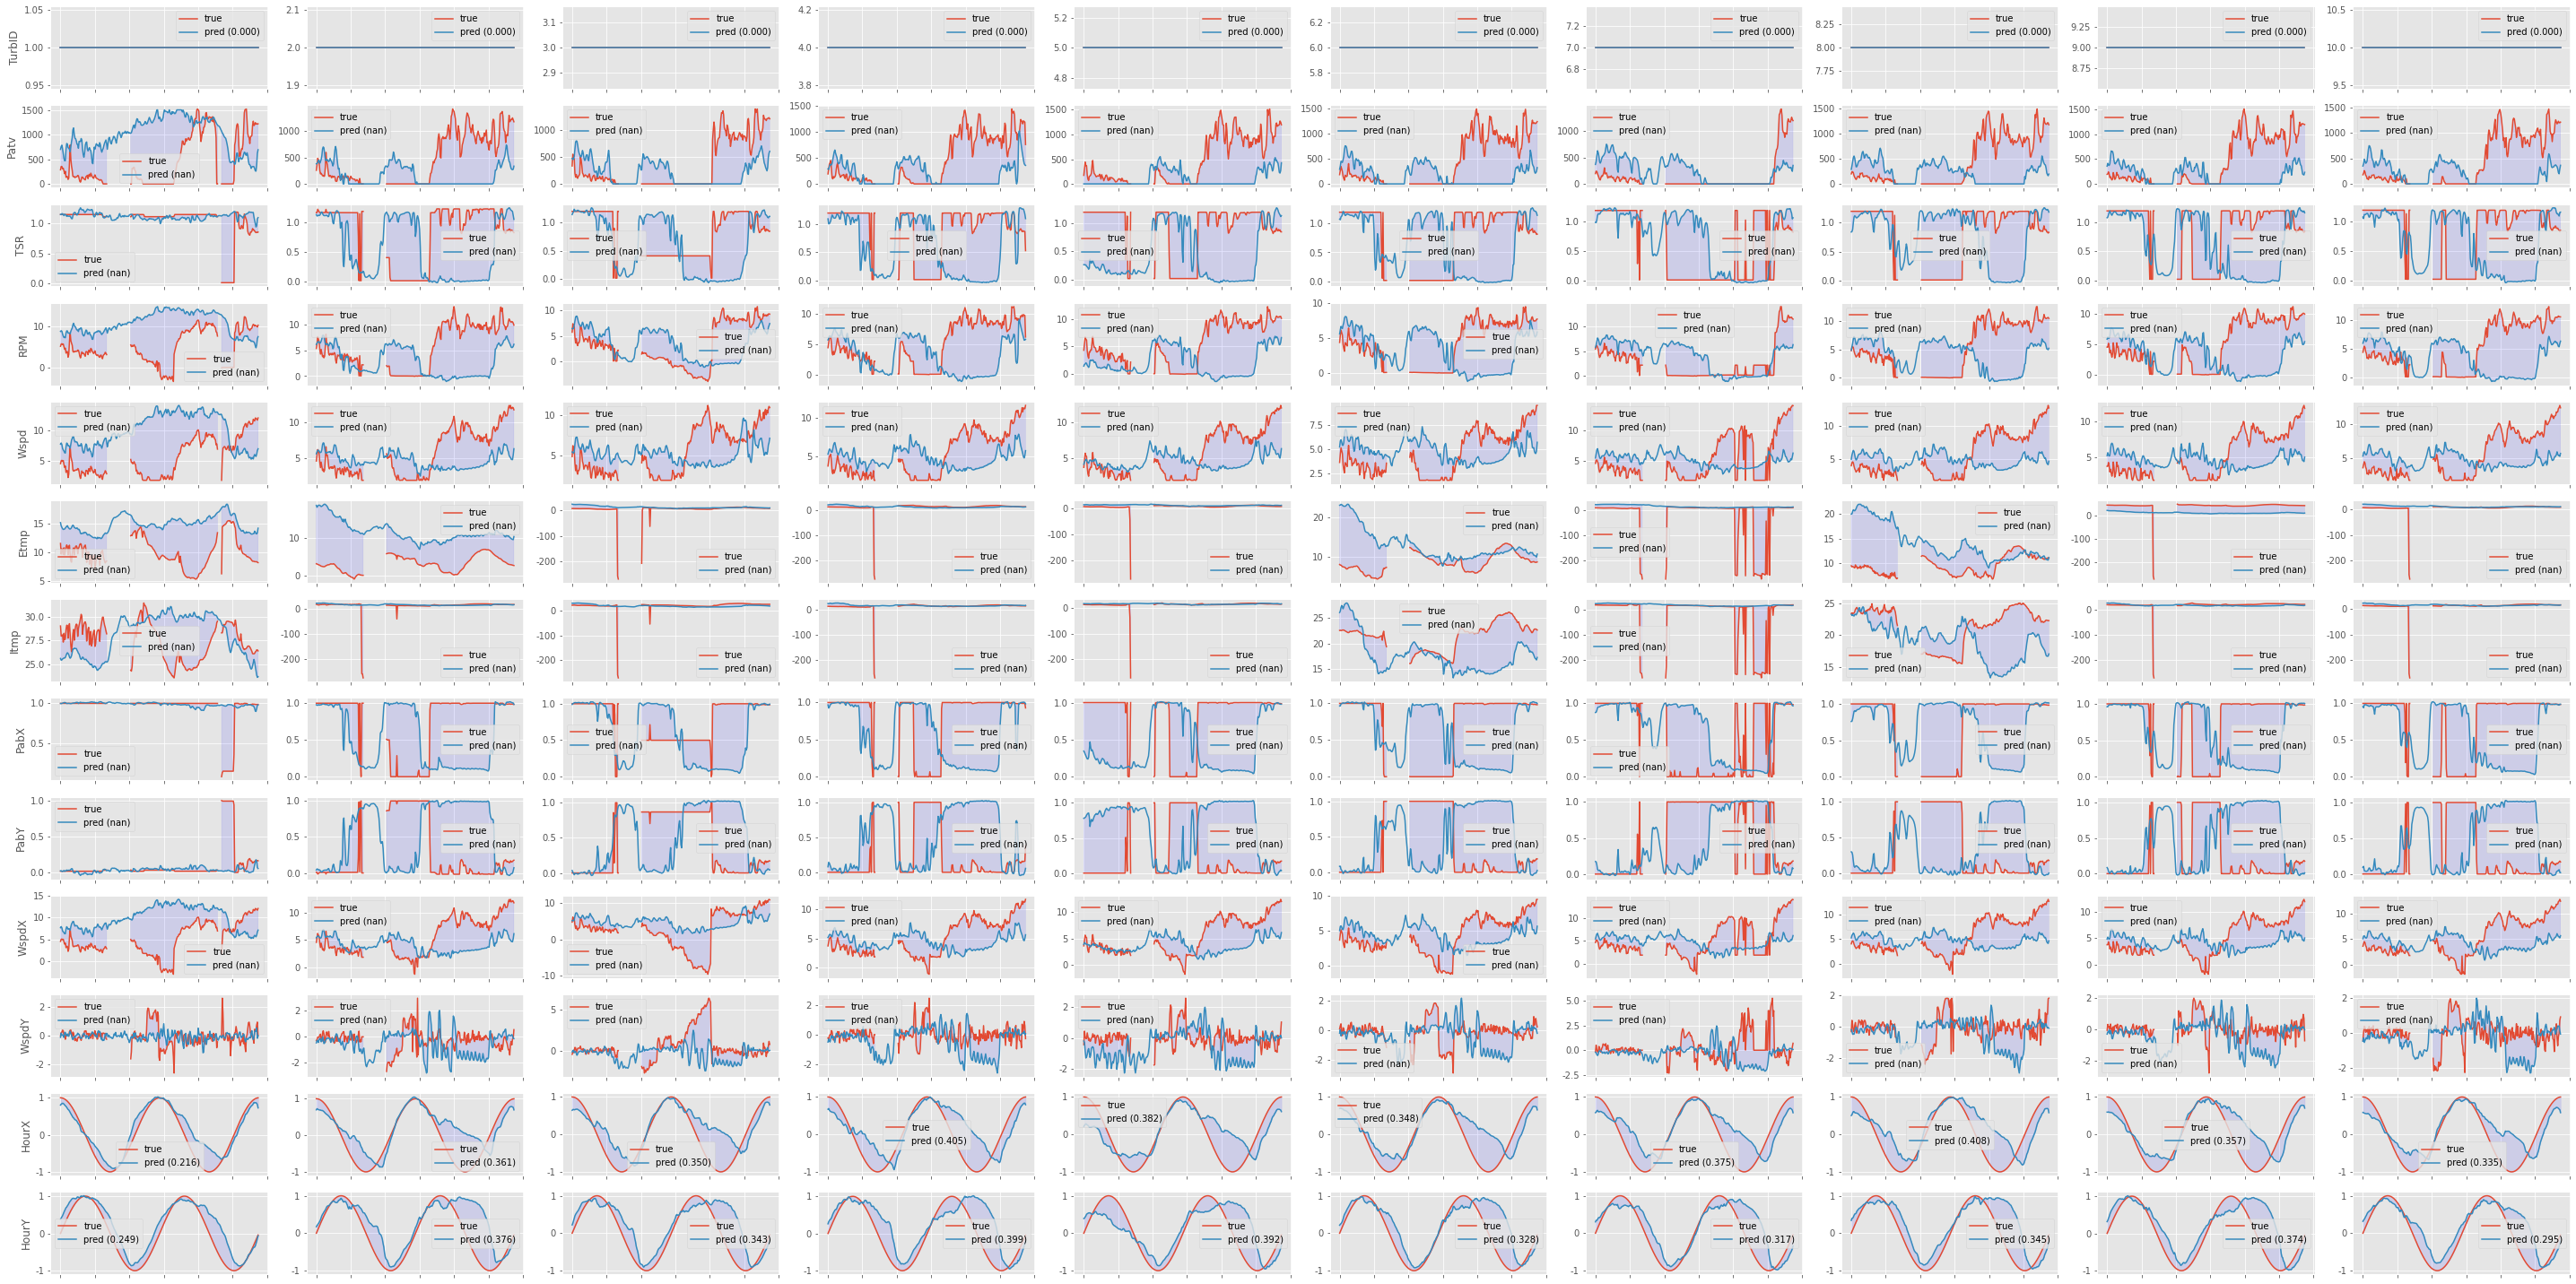

In [26]:
def plot_test_result(model, test_data, n_cols=5):
    y = process_features(test_data).reset_index(drop=True)
    p = pd.concat([pd.DataFrame(inverse_scale(d, scaler), columns=cols + cols_enc + cols_lag) for d in model.predict(test_ds, verbose=0)]).reset_index(drop=True)
    p['TurbID'] = y['TurbID'].values
    
    n_rows = len(cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(40, 20))
    for ax_col, col in zip(axes, cols):
        for idx_row, ax in enumerate(ax_col):
            true = y.query(f"TurbID == {idx_row+1}")[col].values
            pred = p.query(f"TurbID == {idx_row+1}")[col].values

            ax.plot(true, label='true')
            ax.plot(pred, label=f'pred ({np.mean(abs(pred-true)):.3f})')
            ax.fill_between(range(len(true)), true, pred, alpha=0.1, color='b')
            ax.set_xticklabels([])
            ax.legend()
            if idx_row == 0:
                ax.set_ylabel(col)
    fig.tight_layout()
    plt.show()

full_data = pd.read_csv(join(PATH.input, 'wtbdata_245days.csv'))
test_data = full_data[(201 <= full_data['Day']) & (full_data['Day'] <= 202)]
plot_test_result(model, test_data, 10)